#FMO

### Introduction



Hierarchy method reference: link.aps.org/doi/10.1103/PhysRevLett.104.250401

FMO reference http://arxiv.org/pdf/1512.09086v1.pdf
Based on the implementation in http://dx.doi.org/10.1073/pnas.0908989106

In this example notebook we outline how to employ the HEOM to 
solve the FMO photosynthetic complex dynamics. 



In [1]:
%pylab inline
from qutip import *

The history saving thread hit an unexpected error (DatabaseError('database disk image is malformed')).History will not be written to the database.
Populating the interactive namespace from numpy and matplotlib


In [2]:
from qutip.ipynbtools import HTMLProgressBar

In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
from heom_fmotd import BosonicHEOMSolver

In [5]:
#Multiple by h*c*100 to get joules from inverse centimeters

Hsys = Qobj([[200, -87.7, 5.5, -5.9, 6.7, -13.7, -9.9],
                    [-87.7, 320, 30.8, 8.2, 0.7, 11.8, 4.3],
                    [5.5, 30.8, 0, -53.5, -2.2, -9.6, 6.0],
                    [-5.9, 8.2, -53.5, 110, -70.7, -17.0, -63.3],
                    [6.7, 0.7, -2.2, -70.7, 270, 81.1, -1.3],
                    [-13.7,11.8, -9.6, -17.0 ,81.1, 420, 39.7],
                    [-9.9, 4.3, 6.0, -63.3, -1.3, 39.7, 230]])

In [6]:

#start the excitation at site :1:
rho0 = basis(7,0)*basis(7,0).dag() 

#time...  .15 = how many ps?  around 1, but need to get units correct
tlist = np.linspace(0, .15, 800)
tlist2 = np.linspace(0, .15, 800)
eigen_sparse = False
calc_time = True                                             

# might as well use Q as projectors for site populations for plotting, but whatever
P1=basis(7,0) * basis(7,0).dag()
P2=basis(7,1) * basis(7,1).dag()

optionsODE = Options(nsteps=15000, store_states=True,rtol=1e-17,atol=1e-17)
#
Nc = 4
#K is the matsubara terms; if temperature < system energy,  N>1
Nk = 1


In [7]:
#Note here we are comparing matlab results and python results with the boundary condition switched off. There is some inconsistency between 
# the approximation tanimura uses in link.aps.org/doi/10.1103/PhysRevLett.104.250401 (which is what we use in the qutip implementation)  and the one ishizaki uses in 
# http://dx.doi.org/10.1073/pnas.0908989106 (which is slightly different, and the one i use in matlab, to reproduce their  low-temperature data)

#version with all bath parameters the same
lam = 35. 
gamma = 106.  #??? maybe.  need to check units on this parameter
T = 200./0.95
beta = 1/T

#resultHEOM=heom_fmo_no_lists.HSolverDLMultiBaths(idFMO, Q,  lam0,Temperature, Ncc, Kk, gamma,renorm=True,options=optionsODE,bnd_cut_approx=False)


Text(0, 0.5, 'J')

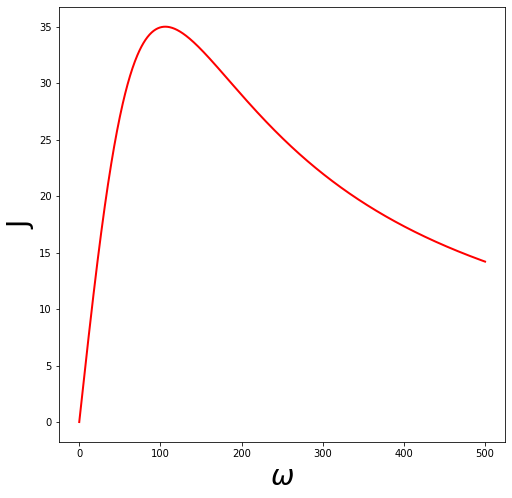

In [8]:
###############################################

# defines cks and vks for the Matsubara decomposition of the Drude Lorentz spectral density


def cot(x):
    return 1./np.tan(x)

wlist = np.linspace(0, 500, 1000)
pref = 1.

J = [w * 2 * lam * gamma / ((gamma**2 + w**2)) for w in wlist]

# Plot the results
fig, axes = plt.subplots(1, 1, sharex=True, figsize=(8,8))
axes.plot(wlist, J, 'r', linewidth=2)
axes.set_xlabel(r'$\omega$', fontsize=28)
axes.set_ylabel(r'J', fontsize=28)



In [9]:
Nk = 1 # number of exponentials in approximation of the Matsubara approximation


def _calc_matsubara_params():
        """
        Calculate the Matsubara coefficents and frequencies
        Returns
        -------
        c, nu: both list(float)
        """
        c = []
        nu = []
        lam0 = lam
        gam = gamma
        hbar = 1
        beta = 1.0/T
        N_m =  Nk

        g = 2*np.pi / (beta)
        for k in range(N_m):
            if k == 0:
                nu.append(gam)
                c.append(lam0*gam*
                    (1.0/np.tan(gam*hbar*beta/2.0) - 1j) / hbar)
            else:
                g = 2*np.pi / (beta)
                nu.append(k*g)
                c.append(4*lam0*gam*nu[k] /
                      ((nu[k]**2 - gam**2)*beta*hbar**2))

    
        return c, nu
 



ctest, nutest=_calc_matsubara_params()

pref = 1

ckAR = [pref * lam * gamma * (cot(gamma / (2 * T))) + 0.j]
ckAR.extend([(pref * 4 * lam * gamma * T *  2 * np.pi * k * T / (( 2 * np.pi * k * T)**2 - gamma**2))+0.j for k in range(1,Nk)])

vkAR = [gamma+0.j]
vkAR.extend([2 * np.pi * k * T + 0.j for k in range(1,Nk)])

ckAI = [pref * lam * gamma * (-1.0) + 0.j]

vkAI = [gamma+0.j]

print(ckAR)
print(ckAI)
print(vkAR)
print(vkAI)

[(14424.187844967773+0j)]
[(-3710+0j)]
[(106+0j)]
[(106+0j)]


In [31]:
Q2[0]

[Quantum object: dims = [[7], [7]], shape = (7, 7), type = oper, isherm = True
 Qobj data =
 [[1. 0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0. 0.]],
 Quantum object: dims = [[7], [7]], shape = (7, 7), type = oper, isherm = True
 Qobj data =
 [[1. 0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0. 0.]]]

In [10]:

#each site is coupled to an independant bath in the site basis
Q=[basis(7,m)*basis(7,m).dag() for m in range(7)  ]

NR = len(ckAR)
NI = len(ckAI)
Q2 = []
ckAR2 = []
ckAI2 = []
vkAR2 = []
vkAI2 = []
for m in range(7):
    Q2.extend([ basis(7,m)*basis(7,m).dag() for kk in range(NR)])
    ckAR2.extend(ckAR)    
    vkAR2.extend(vkAR)
   
for m in range(7):
    Q2.extend([ basis(7,m)*basis(7,m).dag() for kk in range(NI)])
    ckAI2.extend(ckAI)
    vkAI2.extend(vkAI)
    
print(Q2)

options = Options(nsteps=15000, store_states=True, rtol=1e-14, atol=1e-14)


HEOMMats = BosonicHEOMSolver(Hsys, Q2, ckAR2, ckAI2, vkAR2, vkAI2, Nc, options=options)


[Quantum object: dims = [[7], [7]], shape = (7, 7), type = oper, isherm = True
Qobj data =
[[1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0.]], Quantum object: dims = [[7], [7]], shape = (7, 7), type = oper, isherm = True
Qobj data =
[[0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0.]], Quantum object: dims = [[7], [7]], shape = (7, 7), type = oper, isherm = True
Qobj data =
[[0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0.]], Quantum object: dims = [[7], [7]], shape = (7, 7), type = oper, isherm = True
Qobj data =
[[0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0

/mnt/e/Dropbox/Dropbox/notebooks/tarun heom codes/heom_paper_examples/heom_fmotd.py:182: UserWarning: Expected simplified input.
  warnings.warn("Expected simplified input.")
/mnt/e/Dropbox/Dropbox/notebooks/tarun heom codes/heom_paper_examples/heom_fmotd.py:189: UserWarning: Expected simplified input.
  warnings.warn("Expected simplified input.")


In [12]:
output=HEOMMats.run(rho0,tlist)

In [14]:
ckAR2

[(14424.187844967773+0j),
 (14424.187844967773+0j),
 (14424.187844967773+0j),
 (14424.187844967773+0j),
 (14424.187844967773+0j),
 (14424.187844967773+0j),
 (14424.187844967773+0j)]

In [15]:
vkAR2

[(106+0j), (106+0j), (106+0j), (106+0j), (106+0j), (106+0j), (106+0j)]

In [17]:
ckAI2

[(-3710+0j),
 (-3710+0j),
 (-3710+0j),
 (-3710+0j),
 (-3710+0j),
 (-3710+0j),
 (-3710+0j)]

In [18]:
vkAI2

[(106+0j), (106+0j), (106+0j), (106+0j), (106+0j), (106+0j), (106+0j)]

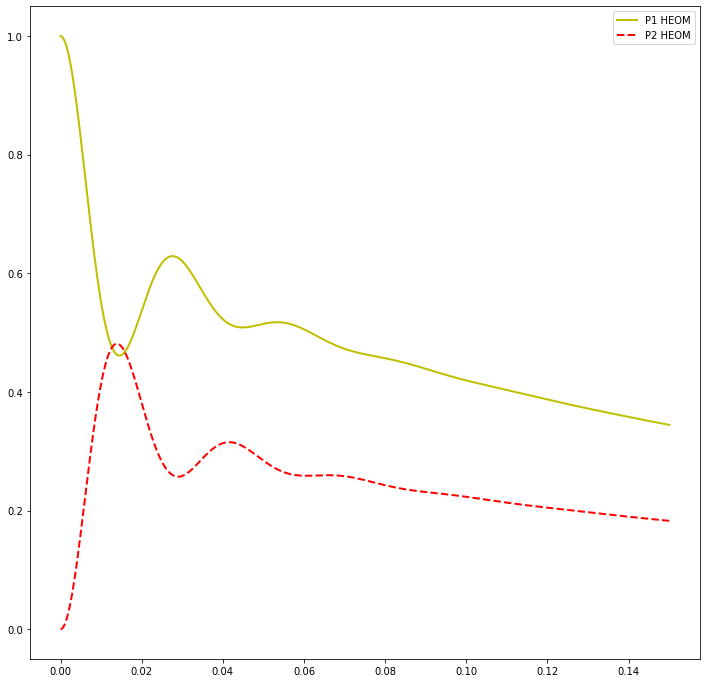

In [13]:
#P1HEOM=expect(output.states,P1)
#P2HEOM=expect(output.states,P2)
P1HEOM=expect(output.states,P1)
P2HEOM=expect(output.states,P2)

fig, axes2 = subplots(1, 1, sharex=True, figsize=(12,12))
#axes2.plot(tlist, resultME.expect[0], 'b', linewidth=2, label="P1 Master Equation")
axes2.plot(tlist2, real(P1HEOM), 'y', linewidth=2, label="P1 HEOM")

#axes2.plot(tlist2, real(MatlabP1), 'g--', linewidth=2, label="P1 HEOM from matlab")
axes2.plot(tlist2, real(P2HEOM), 'r--', linewidth=2, label="P2 HEOM")

axes2.legend(loc=0)

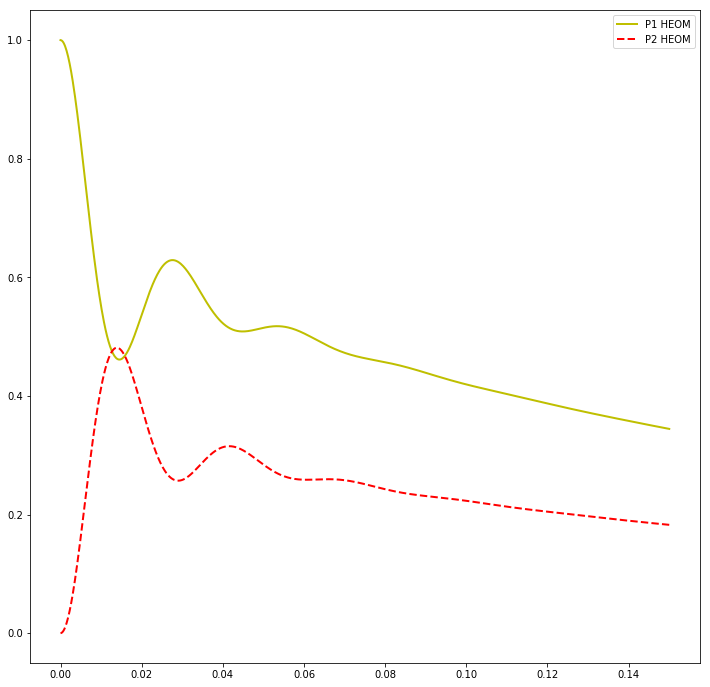

In [10]:
#P1HEOM=expect(output.states,P1)
#P2HEOM=expect(output.states,P2)
P1HEOM=expect(output.states,P1)
P2HEOM=expect(output.states,P2)

fig, axes2 = subplots(1, 1, sharex=True, figsize=(12,12))
#axes2.plot(tlist, resultME.expect[0], 'b', linewidth=2, label="P1 Master Equation")
axes2.plot(tlist2, real(P1HEOM), 'y', linewidth=2, label="P1 HEOM")

#axes2.plot(tlist2, real(MatlabP1), 'g--', linewidth=2, label="P1 HEOM from matlab")
axes2.plot(tlist2, real(P2HEOM), 'r--', linewidth=2, label="P2 HEOM")

axes2.legend(loc=0)

### Comparison to pure dephasing exact result

### Software versions

In [93]:
from qutip.ipynbtools import version_table

version_table()